# A TensorFlow tutorial

In [1]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
import tensorflow as tf

In [2]:
# data source = https://www.kaggle.com/c/leaf-classification
data = pd.read_csv('01-DATA/train.csv')

In [3]:
data.shape

(990, 194)

In [4]:
data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [5]:
nb_classes = len(data['species'].unique())
nb_classes

99

In [6]:
le = preprocessing.LabelEncoder()

In [7]:
y = le.fit_transform(data['species'])

In [8]:
X = data.drop('id', 1).drop('species', 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=487)

# Logistic Regression

In [10]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
print log_loss(y_test, clf.predict_proba(X_test))

4.23374595993


# Random Forest

In [11]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print log_loss(y_test, clf.predict_proba(X_test))

1.80428024212


# TensorFlow

In [12]:
graph = tf.Graph()
with graph.as_default():
    X_train_tf = tf.constant(np.array(X_train).astype(np.float32))
    y_train_tf = tf.constant((np.arange(nb_classes) == y_train[:,None]).astype(np.float32))
    X_test_tf = tf.constant(np.array(X_test).astype(np.float32))
    y_test_tf = tf.constant((np.arange(nb_classes) == y_test[:,None]).astype(np.float32))
    
    weights = tf.Variable(
        tf.truncated_normal([X.shape[1], nb_classes]))
    biases = tf.Variable(tf.zeros([nb_classes]))

    logits = tf.matmul(X_train_tf, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y_train_tf))
    optimizer = tf.train.GradientDescentOptimizer(0.8).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(tf.matmul(X_test_tf, weights) + biases)

In [13]:
num_steps = 10001
train_loss = []
test_loss = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 1000 == 0):
            train_loss.append(l)
            test_loss.append(log_loss(y_test, test_prediction.eval()))
            print('Train Loss at step %d: %f' % (step, l))
            print('Valid Loss: %f'% log_loss(y_test, test_prediction.eval()))

Train Loss at step 0: 4.624413
Valid Loss: 4.631759
Train Loss at step 1000: 4.137475
Valid Loss: 4.195310
Train Loss at step 2000: 3.732263
Valid Loss: 3.823207
Train Loss at step 3000: 3.384432
Valid Loss: 3.503140
Train Loss at step 4000: 3.086440
Valid Loss: 3.228689
Train Loss at step 5000: 2.829750
Valid Loss: 2.991925
Train Loss at step 6000: 2.606733
Valid Loss: 2.785802
Train Loss at step 7000: 2.411375
Valid Loss: 2.604877
Train Loss at step 8000: 2.239062
Valid Loss: 2.445024
Train Loss at step 9000: 2.086184
Valid Loss: 2.303040
Train Loss at step 10000: 1.949856
Valid Loss: 2.176355


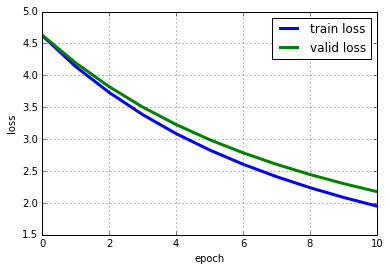

In [14]:
pyplot.plot(train_loss, linewidth=3, label="train loss")
pyplot.plot(test_loss, linewidth=3, label="valid loss")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

# Mini Batch

#### Mini Batch allows a faster gradient descent

In [15]:
batch_size = 64

graph = tf.Graph()
with graph.as_default():
    X_train_tf = tf.placeholder(tf.float32,
                                    shape=(batch_size, X.shape[1]))
    y_train_tf = tf.placeholder(tf.float32, shape=(batch_size, nb_classes))
    X_test_tf = tf.constant(np.array(X_test).astype(np.float32))
    y_test_tf = tf.constant((np.arange(nb_classes) == y_test[:,None]).astype(np.float32))
    
    weights = tf.Variable(
        tf.truncated_normal([X.shape[1], nb_classes]))
    biases = tf.Variable(tf.zeros([nb_classes]))

    logits = tf.matmul(X_train_tf, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y_train_tf))
    optimizer = tf.train.GradientDescentOptimizer(0.8).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(tf.matmul(X_test_tf, weights) + biases)

In [16]:
num_steps = 70001
train_loss = []
test_loss = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (len(y_train) - batch_size)
        # Generate a minibatch.
        batch_data = np.array(X_train)[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size)]
        batch_labels = (np.arange(nb_classes) == batch_labels[:,None]).astype(np.float32)
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {X_train_tf : batch_data, y_train_tf : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 4000 == 0):
            train_loss.append(l)
            test_loss.append(log_loss(y_test, test_prediction.eval()))
            print('Train Loss at step %d: %f' % (step, l))
            print('Valid Loss: %f'% log_loss(y_test, test_prediction.eval()))

Train Loss at step 0: 4.617716
Valid Loss: 4.640052
Train Loss at step 4000: 3.103014
Valid Loss: 3.245315
Train Loss at step 8000: 2.139842
Valid Loss: 2.453359
Train Loss at step 12000: 1.759780
Valid Loss: 1.968372
Train Loss at step 16000: 1.318464
Valid Loss: 1.650348
Train Loss at step 20000: 1.119166
Valid Loss: 1.427687
Train Loss at step 24000: 0.949450
Valid Loss: 1.267724
Train Loss at step 28000: 0.779175
Valid Loss: 1.146158
Train Loss at step 32000: 0.690034
Valid Loss: 1.052394
Train Loss at step 36000: 0.688905
Valid Loss: 0.978355
Train Loss at step 40000: 0.530511
Valid Loss: 0.917245
Train Loss at step 44000: 0.473384
Valid Loss: 0.867600
Train Loss at step 48000: 0.526159
Valid Loss: 0.825346
Train Loss at step 52000: 0.430732
Valid Loss: 0.789898
Train Loss at step 56000: 0.343112
Valid Loss: 0.759255
Train Loss at step 60000: 0.403765
Valid Loss: 0.732507
Train Loss at step 64000: 0.368342
Valid Loss: 0.709447
Train Loss at step 68000: 0.287409
Valid Loss: 0.68857

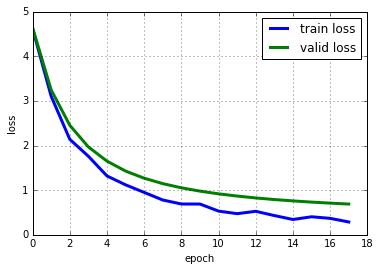

In [17]:
pyplot.plot(train_loss, linewidth=3, label="train loss")
pyplot.plot(test_loss, linewidth=3, label="valid loss")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

# Mini Batch with Relu and 256 hidden layers

#### Increasing network complexity and introducing non-linearities should improve performance 

In [18]:
batch_size = 128
train_loss = []
test_loss = []

graph = tf.Graph()
with graph.as_default():
    X_train_tf = tf.placeholder(tf.float32,
                                    shape=(batch_size, X.shape[1]))
    y_train_tf = tf.placeholder(tf.float32, shape=(batch_size, nb_classes))
    X_test_tf = tf.constant(np.array(X_test).astype(np.float32))
    y_test_tf = tf.constant((np.arange(nb_classes) == y_test[:,None]).astype(np.float32))
    
    weights1 = tf.Variable(
        tf.truncated_normal([X.shape[1], 256]))
    biases1 = tf.Variable(tf.zeros([256]))
    
    weights2 = tf.Variable(
        tf.truncated_normal([256, nb_classes]))
    biases2 = tf.Variable(tf.zeros([nb_classes]))

    h1 = tf.nn.relu(tf.matmul(X_train_tf, weights1) + biases1)
    logits = tf.matmul(h1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y_train_tf))
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    test_prediction_h1 = tf.nn.relu(tf.matmul(X_test_tf, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(test_prediction_h1, weights2) + biases2)

In [19]:
num_steps = 20000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (len(y_train) - batch_size)
        # Generate a minibatch.
        batch_data = np.array(X_train)[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size)]
        batch_labels = (np.arange(nb_classes) == batch_labels[:,None]).astype(np.float32)
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {X_train_tf : batch_data, y_train_tf : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
            train_loss.append(l)
            test_loss.append(log_loss(y_test, test_prediction.eval()))
            print('Train Loss at step %d: %f' % (step, l))
            print('Valid Loss: %f'% log_loss(y_test, test_prediction.eval()))

Train Loss at step 0: 9.716219
Valid Loss: 8.543947
Train Loss at step 1000: 1.845988
Valid Loss: 2.275506
Train Loss at step 2000: 0.903404
Valid Loss: 1.362468
Train Loss at step 3000: 0.411469
Valid Loss: 1.036987
Train Loss at step 4000: 0.260850
Valid Loss: 0.879940
Train Loss at step 5000: 0.185567
Valid Loss: 0.794446
Train Loss at step 6000: 0.166375
Valid Loss: 0.734401
Train Loss at step 7000: 0.136283
Valid Loss: 0.694401
Train Loss at step 8000: 0.100913
Valid Loss: 0.662252
Train Loss at step 9000: 0.101982
Valid Loss: 0.641285
Train Loss at step 10000: 0.071903
Valid Loss: 0.620439
Train Loss at step 11000: 0.074838
Valid Loss: 0.603872
Train Loss at step 12000: 0.061306
Valid Loss: 0.589687
Train Loss at step 13000: 0.064904
Valid Loss: 0.579660
Train Loss at step 14000: 0.047869
Valid Loss: 0.569570
Train Loss at step 15000: 0.071436
Valid Loss: 0.559656
Train Loss at step 16000: 0.040468
Valid Loss: 0.553105
Train Loss at step 17000: 0.067016
Valid Loss: 0.547071
Train

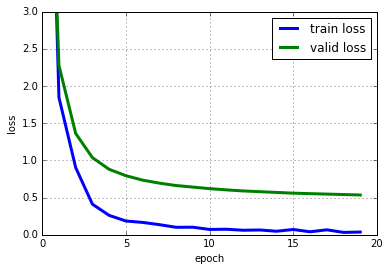

In [20]:
pyplot.plot(train_loss, linewidth=3, label="train loss")
pyplot.plot(test_loss, linewidth=3, label="valid loss")
pyplot.grid()
pyplot.legend()
pyplot.ylim(0, 3.0)
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

#### Train loss is far lower than valid loss : we probably overfit, but still valid loss is not so bad ;)